In [546]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [547]:
def loadData (flow, meta):
    df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
    df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']
    df1['datetime'] = pd.to_datetime(df1[['Year', 'Mnth', 'Day']].rename(columns={'Year': 'year', 'Mnth': 'month', 'Day': 'day'}))
    df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)
    df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)
    df = pd.concat([df1, df2], axis=1)
    df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
    df.set_index('datetime', inplace=True)
    df.drop(['Hr'], axis=1, inplace=True)
    before = 3
    after = 3
    # for i in range(1, before + 1):
    #     df[f'Flow-{i}'] = df['Flow0'].shift(+i)  # Shift down by 1   
    for i in  range(1, after + 1):
        df[f'Flow+{i}'] = df['Flow0'].shift(-i)  # Shift up by 1   
    df = df.dropna()
    return df


In [548]:
df = loadData('Data/Idaho/13340000_streamflow_qc.txt', 'Data/Idaho/13340000_lump_maurer_forcing_leap.txt')


C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [549]:
def expand_mean(df):
    return df.expanding(1).mean()
def pct_diff(old, new):
    return (new-old) / old
def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"

    df[label] = df[col].rolling(horizon).mean()
    df[f"{label}_pct"] = pct_diff(df[label], df[col])
    return df

rolling_horizons = [3, 14]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'Flow0', 'vp(Pa)']:
        df = compute_rolling(df, horizon, col)

df = df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'Flow0', 'vp(Pa)']:
    df[f'month_avg_{col}'] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
    df[f'day_avg_{col}'] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)

In [550]:
features_to_drop = [
    'swe(mm)',
    'SYM_nan',
    'rolling_3_srad(W/m2)', 
    'rolling_3_tmax(C)', 
    'rolling_3_tmin(C)', 
    'rolling_14_prcp(mm/day)_pct', 
    'rolling_14_srad(W/m2)', 
    'rolling_14_tmax(C)_pct', 
    'rolling_14_tmin(C)_pct', 
    'rolling_14_vp(Pa)', 
    'rolling_14_vp(Pa)_pct', 
    'month_avg_prcp(mm/day)', 
    'month_avg_srad(W/m2)', 
    'day_avg_tmax(C)', 
    'month_avg_tmin(C)', 
    'day_avg_tmin(C)', 
    'month_avg_Flow0'
]

# Drop the features from the DataFrame
df = df.drop(columns=features_to_drop)


In [551]:

Y = df['Flow+1']  # Target variable
adjX = df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
X = adjX.columns

In [552]:
# def backtest(df, model, X, Y, start=3650, step=90):
#     all_predictions = []

#     # Ensure Y is a Series and X is a list of column names
#     if isinstance(Y, pd.Series):
#         Y = Y.name 

#     # if isinstance(X, pd.DataFrame):
#         #     X = X.columns.tolist()
#     for i in range(start, df.shape[0], step):
#         train = df.iloc[:i,:]
#         test = df.iloc[i:(i+step),:]
            
#         X_train = train[X]
#         Y_train = train[Y]
#         X_test = test[X]

#         model.fit(X_train, Y_train, epochs=10)

#         preds = model.predict(X_test)

#         preds = pd.Series(preds.flatten(), index=test.index)
#         combined = pd.concat([test[Y], preds], axis=1)

#         combined.columns = ["actual", "prediction"]
#         combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

#         all_predictions.append(combined)
#     return pd.concat(all_predictions, axis=0)

In [553]:
# def permutation_importance(model, X_test, y_test, metric=mean_squared_error):
#     baseline_score = metric(y_test, model.predict(X_test))
#     importances = []
    
#     for i in range(X_test.shape[1]):
#         X_test_permuted = X_test.copy()
#         np.random.shuffle(X_test_permuted[:, i])
#         permuted_score = metric(y_test, model.predict(X_test_permuted))
#         importances.append(permuted_score - baseline_score)
    
#     return np.array(importances)

In [554]:
def backtest(df, model, X, Y, start=7300, step=90):
    all_predictions = []
    # feature_importances = np.zeros(len(X))
    
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    # Ensure Y is a column name if it is a pandas Series
    if isinstance(Y, pd.Series):
        Y_column = Y.name
    else:
        Y_column = Y  # Y should be a string representing the column name

 # Implement EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        X_train = train[X]
        X_train = scaler_X.fit_transform(X_train)

        X_test = test[X]
        X_test = scaler_X.transform(test[X])
        
        Y_train = train[[Y_column]]
        Y_train = scaler_Y.fit_transform(Y_train).reshape(-1, 1) 

        Y_test = test[[Y_column]]
        Y_test = scaler_Y.transform(Y_test).reshape(-1, 1) 


        # Fit the model on the scaled training data
        model.fit(X_train, Y_train, epochs=20, verbose=1, validation_split=0.2, callbacks=[early_stopping])

        # Predict using the scaled test data
        preds = model.predict(X_test)

        # Flatten predictions and align with test index
        preds = scaler_Y.inverse_transform(preds).reshape(-1, 1).flatten() 
        Y_test = scaler_Y.inverse_transform(Y_test).reshape(-1, 1).flatten()

        combined = pd.DataFrame({
            "actual": Y_test,
            "prediction": preds
        }, index=test.index)


        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)

        #     # Calculate permutation importance
        # importances = permutation_importance(model, X_test, Y_test)
        # feature_importances += importances

    all_predictions = pd.concat(all_predictions, axis=0)

    # avg_feature_importances = feature_importances / len(range(start, df.shape[0], step))
    
    # for i, importance in enumerate(avg_feature_importances):
    #     print(f"Feature: {X[i]}, Importance: {importance}")

    return all_predictions, scaler_X, scaler_Y

In [555]:

model = keras.Sequential([
            Dense(64, activation='relu', input_shape=(X.shape[0],), kernel_regularizer='l2'),
            Dropout(0.2),
            Dense(32, activation='relu', kernel_regularizer='l2'),
            Dropout(0.2),
            Dense(1)])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


# Summary to see the architecture
model.summary()


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_152 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

In [556]:
predictions, scaler_X, scaler_Y = backtest(df, model, X, Y)

y_pred = predictions["prediction"]
y_test = predictions["actual"]

Epoch 1/20


183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3303 - mean_squared_error: 0.5291 - val_loss: 0.7004 - val_mean_squared_error: 0.1071
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - mean_squared_error: 0.1173 - val_loss: 0.4681 - val_mean_squared_error: 0.0674
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4484 - mean_squared_error: 0.0841 - val_loss: 0.3454 - val_mean_squared_error: 0.0752
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3292 - mean_squared_error: 0.0823 - val_loss: 0.2658 - val_mean_squared_error: 0.0799
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2357 - mean_squared_error: 0.0640 - val_loss: 0.2052 - val_mean_squared_error: 0.0731
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1761 - mean_squared_error: 0.0533 - val_loss: 0.1459 - val_mean_squared_error: 0.0481
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 - mean_squared_error: 0.0580 - val_loss: 0.1209 - val_me

In [557]:
def visualization (y_pred, y_test, zoom_start, zoom_end):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 - np.mean(mape)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {round(mae, 2)} m3/s")
    print(f"MSE: {round(mse, 2)} m3/s")
    print(f"MAPE: {round(mape, 2)}%")
    print(f"Accuracy: {round(accuracy, 3)}%")
    print(f"R2: {round(r2, 4)}")
    plt.figure(figsize=(14, 8))
    # # Plot Actual vs Predicted for each Flow
    # for i in range(y_pred.shape[0]):
    #     plt.plot(range(len(y_test)), y_test[:, i], label=f'Actual Flow+{i}', color='black')
    #     plt.plot(range(len(y_pred)), y_pred[:, i], label=f'Predicted Flow+{i}', color=f'C{i}')

    plt.plot(range(len(y_test)), y_test, label=f'Actual Flow', color='black')
    plt.plot(range(len(y_pred)), y_pred, label=f'Predicted Flow', color=f'C0')

    plt.xlabel('Index')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))

    # Plot Actual vs Predicted for Flow
    plt.plot(range(len(y_test)), y_test, label='Actual Flow', color='black')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted Flow', color='C0')

    plt.xlabel('Index')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values')

    # Set the x and y limits to zoom in
    plt.xlim(zoom_start, zoom_end)
    plt.ylim(min(y_test[zoom_start:zoom_end].min(), y_pred[zoom_start:zoom_end].min()), 
            max(y_test[zoom_start:zoom_end].max(), y_pred[zoom_start:zoom_end].max()))

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

MAE: 838.73 m3/s
MSE: 2054797.03 m3/s
MAPE: 0.2%
Accuracy: 99.799%
R2: 0.9781


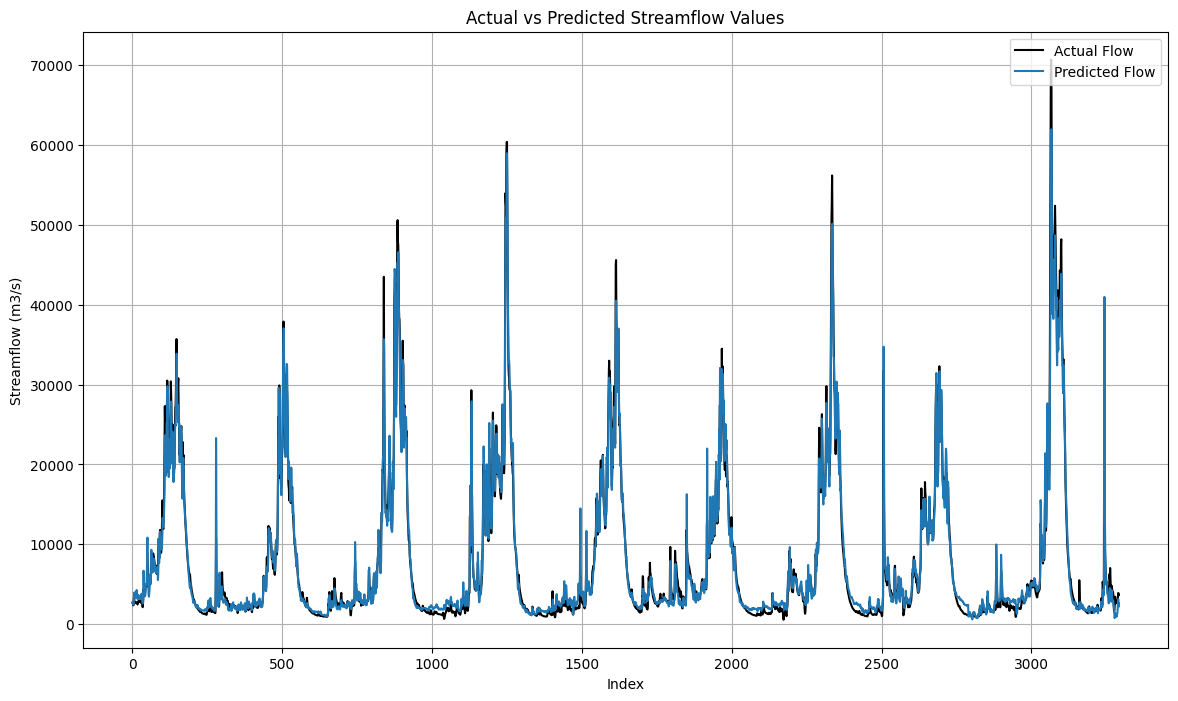

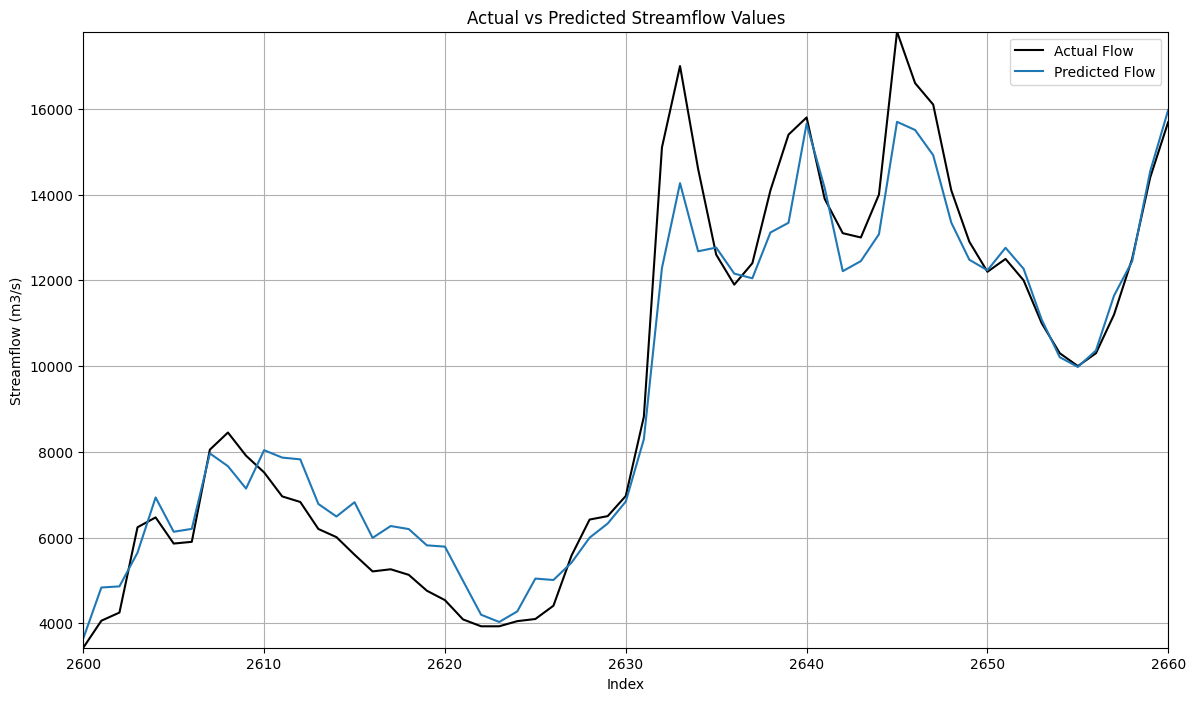

In [558]:
visualization(y_pred, y_test, 2600, 2660)

In [559]:
new_df = loadData('Data/Idaho/05131500_streamflow_qc.txt', 'Data/Idaho/05131500_lump_maurer_forcing_leap.txt')

rolling_horizons = [3, 14]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'Flow0', 'vp(Pa)']:
        new_df = compute_rolling(new_df, horizon, col)

new_df = new_df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'Flow0', 'vp(Pa)']:
    new_df[f'month_avg_{col}'] = new_df[col].groupby(new_df.index.month, group_keys=False).apply(expand_mean)
    new_df[f'day_avg_{col}'] = new_df[col].groupby(new_df.index.day_of_year, group_keys=False).apply(expand_mean)


C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [560]:
# List of features to drop based on importance scores
features_to_drop = [
    'swe(mm)',
    'SYM_nan',
    'rolling_3_srad(W/m2)', 
    'rolling_3_tmax(C)', 
    'rolling_3_tmin(C)', 
    'rolling_14_prcp(mm/day)_pct', 
    'rolling_14_srad(W/m2)', 
    'rolling_14_tmax(C)_pct', 
    'rolling_14_tmin(C)_pct', 
    'rolling_14_vp(Pa)', 
    'rolling_14_vp(Pa)_pct', 
    'month_avg_prcp(mm/day)', 
    'month_avg_srad(W/m2)', 
    'day_avg_tmax(C)', 
    'month_avg_tmin(C)', 
    'day_avg_tmin(C)', 
    'month_avg_Flow0'
]

# Drop the features from the DataFrame
new_df = new_df.drop(columns=features_to_drop)

Y_new = new_df['Flow+1']  # Target variable
X_new = new_df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
X_new = X_new.columns

predictions_new, scaler_X, scaler_Y = backtest(new_df, model, X_new, Y_new)

# X_new = scaler_X.transform(X_new)
# # Y_new = scaler_Y.transform(Y_new)

# # Step 3: Make predictions
# predictions_new = model.predict(X_new)

# # If needed, inverse transform predictions_new
# predictions_new = scaler_Y.inverse_transform(predictions_new)

# # Step 4: Create a DataFrame to store the results
# results = pd.DataFrame(predictions_new, columns=['Predictions'], index=new_df.index)

# # Optional: Add the actual target values if available
# results['Actual'] = Y_new

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1279 - mean_squared_error: 0.1101 - val_loss: 0.0721 - val_mean_squared_error: 0.0506
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1116 - mean_squared_error: 0.0894 - val_loss: 0.0839 - val_mean_squared_error: 0.0626
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0908 - mean_squared_error: 0.0697 - val_loss: 0.0816 - val_mean_squared_error: 0.0602
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0836 - mean_squared_error: 0.0619 - val_loss: 0.0732 - val_mean_squared_error: 0.0522
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1113 - mean_squared_error: 0.0899 - val_loss: 0.1320 - val_mean_squared_error: 0.1108
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0763 - mean_squared_error: 0.0555 - val_loss: 0.0736 - val_mean_squared_error: 0.0505
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0829 - mean_

MAE: 165.14 m3/s
MSE: 146178.64 m3/s
MAPE: 0.41%
Accuracy: 99.585%
R2: 0.9453


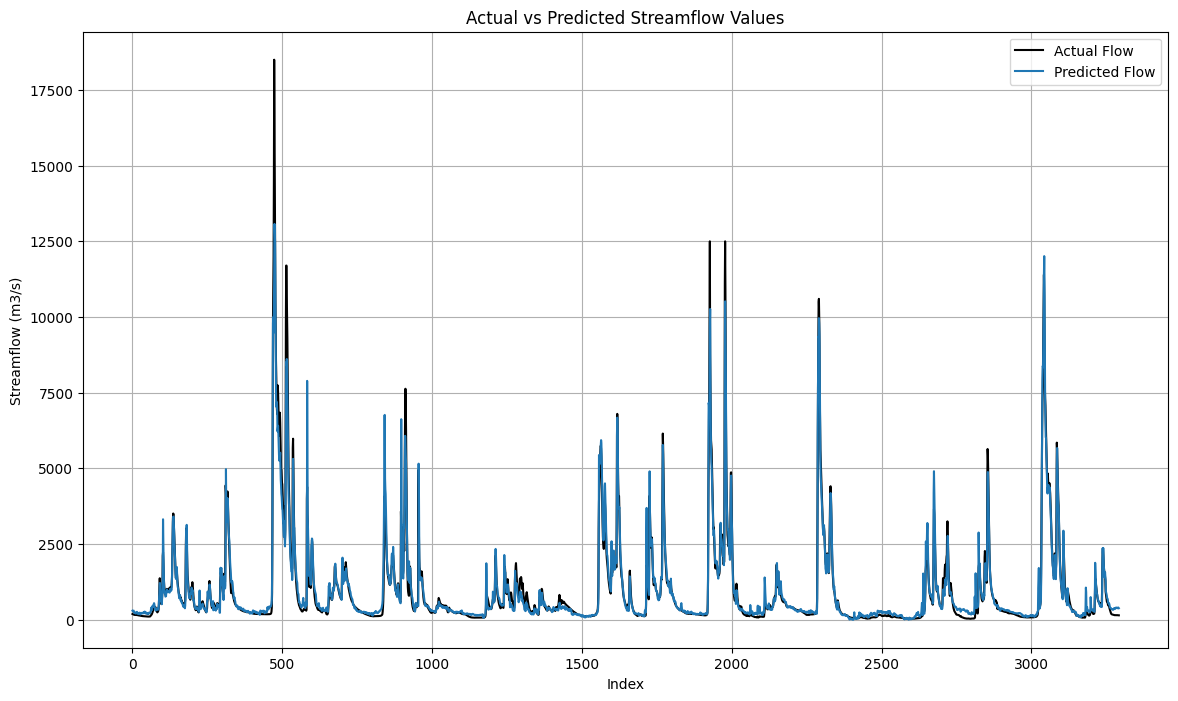

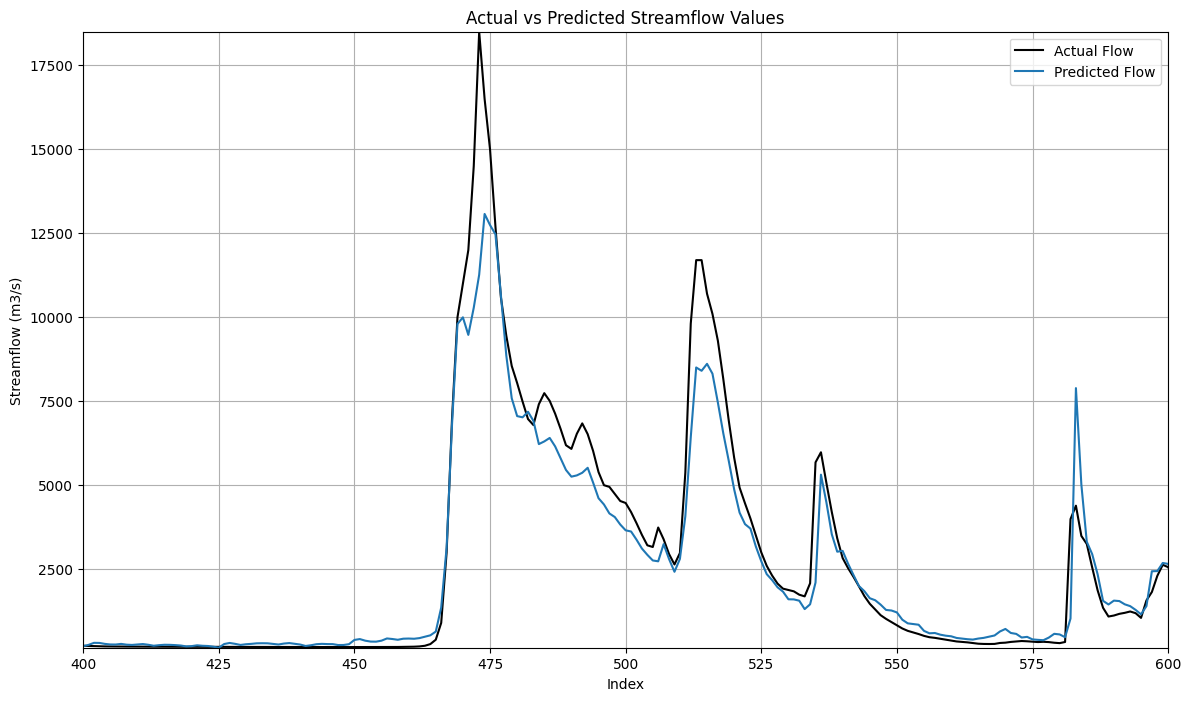

In [562]:
y_pred_new = predictions_new["prediction"]
y_test_new = predictions_new["actual"]
y_pred_new = np.maximum(y_pred_new, 0)  # Ensure no negative predictions
y_pred_new = np.minimum(y_pred_new, np.max(y_test_new) * 2)  # Cap predictions at 10% above max value of y_test

visualization(y_pred_new, y_test_new, 400, 600)